In [1]:
import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from mnist_loader import MNISTDataset, train_test_split
from autoencoders import (
    SimpleEncoder, 
    SimpleDecoder, 
    DeepEncoder,
    DeepDecoder,
    AutoEncoder,
)
from functions import train_model, ImagePlotter

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
np.random.seed(42)
torch.random.manual_seed(42)

LATENT_DIM = 50

In [3]:
mnist = datasets.MNIST('/home/andrei/datasets') 
# use data and targets only, supports __getitem__, 60000 images 28x28 px

In [4]:
train, test, plot_idx, labels = train_test_split(train_ratio=0.8, mnist=mnist)

In [5]:
image_transforms = transforms.ToTensor()
trainset = MNISTDataset(train, mnist, image_transforms)
testset = MNISTDataset(test, mnist, image_transforms)

In [6]:
trainloader = DataLoader(trainset, shuffle=True, batch_size=256, num_workers=8)
testloader = DataLoader(testset, shuffle=False, batch_size=256, num_workers=8)

In [7]:
device = torch.device('cpu')

## Deep autoencoder

Three hidden layers

In [8]:
encoder = DeepEncoder(num_features=LATENT_DIM)
decoder = DeepDecoder(num_features=LATENT_DIM)

model = AutoEncoder(encoder, decoder)
model.to(device)
model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

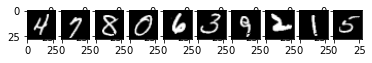

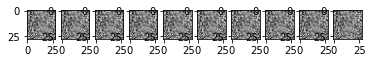

test loss: 32.5928
 Epoch 0, train loss: 55.9059, test loss: 11.5389


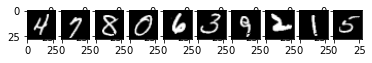

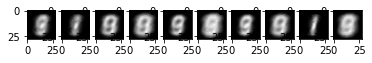

 Epoch 1, train loss: 41.6343, test loss: 8.7079


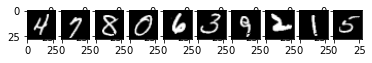

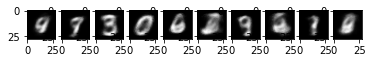

 Epoch 2, train loss: 31.5890, test loss: 7.3108


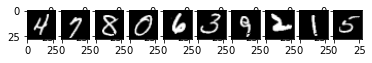

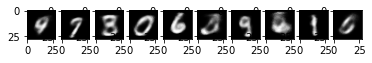

 Epoch 3, train loss: 27.9832, test loss: 6.7232
 Epoch 4, train loss: 26.4100, test loss: 6.4419
 Epoch 5, train loss: 25.3920, test loss: 6.1891
 Epoch 6, train loss: 24.3213, test loss: 5.9365
 Epoch 7, train loss: 23.3409, test loss: 5.7285
 Epoch 8, train loss: 22.5717, test loss: 5.5292
 Epoch 9, train loss: 21.9568, test loss: 5.3860


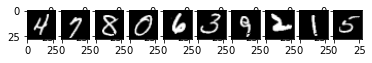

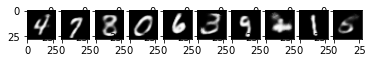

 Epoch 10, train loss: 21.4119, test loss: 5.2980
 Epoch 11, train loss: 21.0082, test loss: 5.1886
 Epoch 12, train loss: 20.6302, test loss: 5.1161
 Epoch 13, train loss: 20.2925, test loss: 5.0290
 Epoch 14, train loss: 19.9897, test loss: 4.9544
 Epoch 15, train loss: 19.7373, test loss: 4.9064
 Epoch 16, train loss: 19.4802, test loss: 4.8517
 Epoch 17, train loss: 19.2494, test loss: 4.7989
 Epoch 18, train loss: 19.0415, test loss: 4.7297
 Epoch 19, train loss: 18.8431, test loss: 4.6875


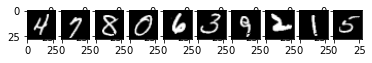

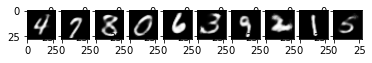

 Epoch 20, train loss: 18.6383, test loss: 4.6467
 Epoch 21, train loss: 18.4690, test loss: 4.6079
 Epoch 22, train loss: 18.3047, test loss: 4.5631
 Epoch 23, train loss: 18.1678, test loss: 4.5383
 Epoch 24, train loss: 18.0135, test loss: 4.5057
 Epoch 25, train loss: 17.8916, test loss: 4.4679
 Epoch 26, train loss: 17.7600, test loss: 4.4414
 Epoch 27, train loss: 17.6712, test loss: 4.4112
 Epoch 28, train loss: 17.5785, test loss: 4.4022
 Epoch 29, train loss: 17.4971, test loss: 4.3701


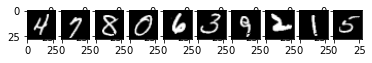

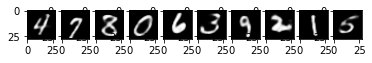

 Epoch 30, train loss: 17.4089, test loss: 4.3679
 Epoch 31, train loss: 17.3315, test loss: 4.3324
 Epoch 32, train loss: 17.2429, test loss: 4.3243
 Epoch 33, train loss: 17.1659, test loss: 4.2968
 Epoch 34, train loss: 17.0794, test loss: 4.2805
 Epoch 35, train loss: 17.0071, test loss: 4.2501
 Epoch 36, train loss: 16.9302, test loss: 4.2393
 Epoch 37, train loss: 16.8424, test loss: 4.2326
 Epoch 38, train loss: 16.7831, test loss: 4.1959
 Epoch 39, train loss: 16.6927, test loss: 4.1920


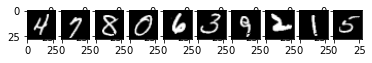

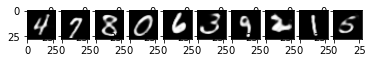

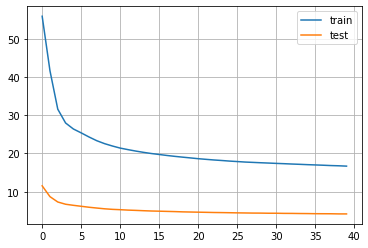

In [9]:
image_plotter = ImagePlotter(image_transforms=image_transforms, mnist=mnist, indexes=plot_idx)

model, optimizer = train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    epochs=40,
    image_plotter=image_plotter,
)


## Generate latents, plot, test

In [10]:
image_latents = []
image_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        model_images, latents = model(images)
        image_latents.append(latents)
        image_labels.append(labels)
        
image_labels = torch.hstack(image_labels)
image_latents = torch.vstack(image_latents)

print(image_labels.shape)
print(image_latents.shape)

torch.Size([12000])
torch.Size([12000, 1, 50])


In [11]:
tsne = TSNE()

In [13]:
x_tsne = tsne.fit_transform(X=image_latents.reshape(12000, LATENT_DIM).detach().cpu().numpy())

In [14]:
y_tsne = image_labels.reshape(12000,).detach().cpu().numpy()

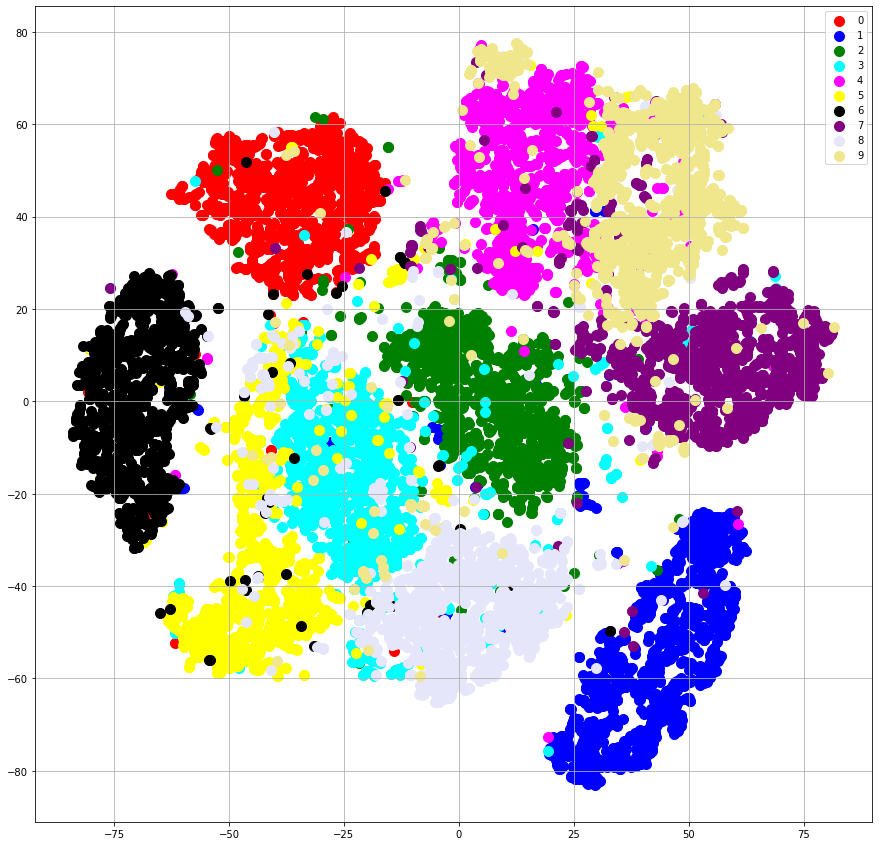

In [15]:
scatter_x = x_tsne[:, 0]
scatter_y = x_tsne[:, 1]
group = y_tsne
cdict = {
    0: 'red', 1: 'blue', 2: 'green', 
    3: "cyan", 4: "magenta", 5: "yellow", 
    6: "black", 7: "purple", 8: "lavender", 9: "khaki"}

fig, ax = plt.subplots(figsize=(15, 15))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[g], label=g, s=100)
ax.legend()
plt.grid()
plt.show()

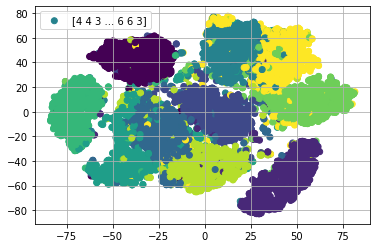

In [16]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_tsne, label=y_tsne)
plt.legend()
plt.grid()

In [17]:
start = image_latents[3062]
start_label = image_labels[3062]

end = image_latents[9473]
end_label = image_labels[9473]

In [18]:
start_label, end_label

(tensor(5), tensor(5))

In [20]:
vectors = np.linspace(
    start.detach().cpu().numpy().reshape(LATENT_DIM, ),
    end.detach().cpu().numpy().reshape(LATENT_DIM, ),
    10,
)

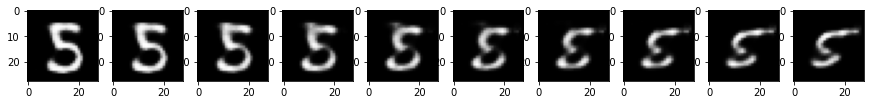

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15, 1.5))
for i, vec in enumerate(vectors):
    img = model.decoder(torch.tensor(vec).unsqueeze(0))
    ax[i].imshow(img.detach().cpu().numpy().reshape(28, 28), cmap="gray")


In [22]:
start = image_latents[14]
start_label = image_labels[14]

end = image_latents[9473]
end_label = image_labels[9473]

start_label, end_label

(tensor(1), tensor(5))

In [23]:
vectors = np.linspace(
    start.detach().cpu().numpy().reshape(LATENT_DIM, ),
    end.detach().cpu().numpy().reshape(LATENT_DIM, ),
    10
)

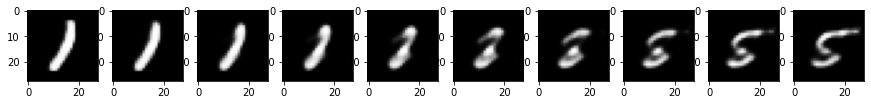

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15, 1.5))
for i, vec in enumerate(vectors):
    img = model.decoder(torch.tensor(vec).unsqueeze(0))
    ax[i].imshow(img.detach().cpu().numpy().reshape(28, 28), cmap="gray")
